# Electron Photon tagging

I test a classical variational autoencoder on the electron photon dataset

### imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import CAE as cae
from tensorflow.keras import layers, losses
from matplotlib.colors import LogNorm
import h5py
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

2022-07-18 19:29:20.447684: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-18 19:29:20.447703: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/cirq/ops/gateset.py:376: UserWarning: v0.14.1 is the last release `cirq.GlobalPhaseGate` is included by default. If you were relying on this behavior, you can include a `cirq.GlobalPhaseGate` in your `*gates`. If not, then you can ignore this warning. It will be removed in v0.16
  warnings.warn(
2022-07-18 19:29:21.609150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-18 19:29:21.609171: W tensorflow/

## Data 

In [3]:
f = h5py.File("../../data/electron.hdf5","r")
f2 = h5py.File("../../data/photon.hdf5","r")

In [5]:
electrons = f.get('X')[:,:,:,0]
photons = f2.get('X')[:,:,:,0]
electrons_y = f.get('y')[:]
photons_y = f2.get('y')[:]

In [6]:
x_train, x_val, y_train, y_val = train_test_split(np.vstack((electrons,photons)),
                                                    np.transpose(np.hstack((electrons_y, photons_y))),
                                                    test_size=0.2, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,
                                                    test_size=0.4, shuffle=True)

In [7]:
x_train_electrons = x_train[y_train==1]
x_train = x_train[y_train==0]

x_val_electrons = x_val[y_val==1]
x_val = x_val[y_val==0]

x_test_electrons = x_test[y_test==1]
x_test = x_test[y_test==0]

In [8]:
x_train = x_train.reshape(x_train.shape + (1,))
x_train_electrons = x_train_electrons.reshape(x_train_electrons.shape + (1,))

x_val = x_val.reshape(x_val.shape + (1,))
x_val_electrons = x_val_electrons.reshape(x_val_electrons.shape + (1,))

x_test = x_test.reshape(x_test.shape + (1,))
x_test_electrons = x_test_electrons.reshape(x_test_electrons.shape + (1,))

## VAE model

In [9]:
ae = cae.VAE()

In [10]:
ae.compile(optimizer=tf.keras.optimizers.Adam(0.000001))

In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='reconstruction_loss', patience=2)
hist = ae.fit(x_train,
                epochs=20,
                shuffle=True,
                #validation_data=x_test,
                callbacks=[es])

Epoch 1/20
3749/3749 [==============================] - 63s 17ms/step - loss: 703.3834 - reconstruction_loss: 694.0292 - kl_loss: 0.0670
Epoch 2/20
3749/3749 [==============================] - 61s 16ms/step - loss: 629.9912 - reconstruction_loss: 552.9076 - kl_loss: 11.3486
Epoch 3/20
3749/3749 [==============================] - 60s 16ms/step - loss: 290.4435 - reconstruction_loss: 165.5497 - kl_loss: 63.4718
Epoch 4/20
3749/3749 [==============================] - 60s 16ms/step - loss: 111.0120 - reconstruction_loss: 51.6416 - kl_loss: 39.7865
Epoch 5/20
3749/3749 [==============================] - 62s 16ms/step - loss: 50.8637 - reconstruction_loss: 22.9819 - kl_loss: 20.3305
Epoch 6/20
3749/3749 [==============================] - 60s 16ms/step - loss: 27.0219 - reconstruction_loss: 12.7702 - kl_loss: 11.0621
Epoch 7/20
3749/3749 [==============================] - 60s 16ms/step - loss: 16.6696 - reconstruction_loss: 8.7056 - kl_loss: 6.5247
Epoch 8/20
3749/3749 [======================

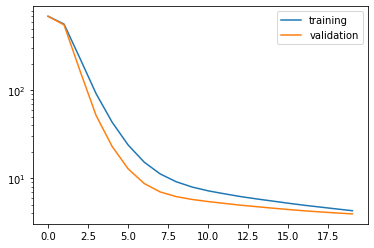

In [12]:
plt.plot(hist.history['loss'], label="training")
plt.plot(hist.history['reconstruction_loss'], label="validation")
plt.yscale('log')
plt.legend()

## Evaluation

In [13]:
def mae(x):
    pred = ae.predict(x)
    return np.mean(np.abs(x - pred)**2,axis=(1,2,3))

def recon_acc(x):
    return 1 - mae(x)

In [14]:
photons = recon_acc(x_test)
electrons = recon_acc(x_test_electrons)

In [15]:
photon_energy = np.sum(x_test,axis=(1,2,3))
electron_energy = np.sum(x_test_electrons,axis=(1,2,3))

0.9998498
0.9998787


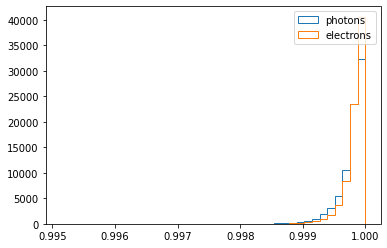

In [16]:
print(np.median(photons))
bins = np.histogram(np.hstack((photons, electrons)), bins=40)[1]
plt.hist(photons, histtype='step', label="photons",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
print(np.median(electrons))
plt.hist(electrons, histtype='step', label="electrons",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
plt.legend()

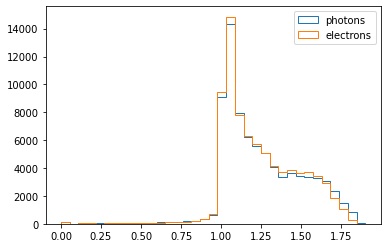

In [17]:
bins = np.histogram(np.hstack((photon_energy, electron_energy)), bins=35)[1]
plt.hist(photon_energy, histtype='step', label="photons",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
plt.hist(electron_energy, histtype='step', label="electrons",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
plt.legend()

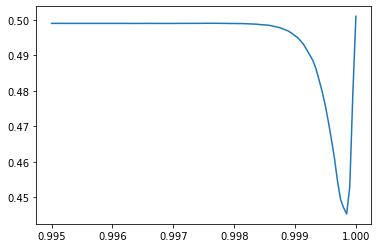

In [18]:
def acc_for_threshold(T):
    # sixes that are predicted photon
    num_six_right = np.sum(photons > T)
    # threes that are predicted three
    num_three_right = np.sum(electrons < T)
   
    acc = (num_six_right + num_three_right)/(len(photons) + len(electrons))
    return acc

Ts = np.linspace(0.995,1,100)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
plt.plot(Ts, accs) 

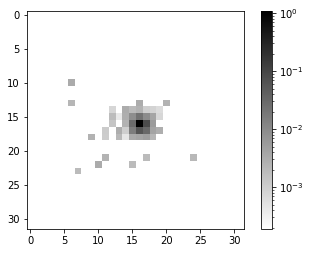

In [79]:
num = 50
testimg = ae.predict(x_test[num].reshape((1,32,32,1)))
plt.imshow(x_test[num].reshape((32,32)),cmap="binary",norm=LogNorm())
plt.colorbar()

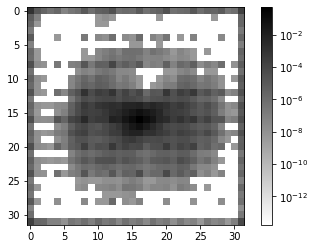

In [80]:
plt.imshow(testimg.reshape((32,32)),cmap="binary",norm=LogNorm())
plt.colorbar()